### Machine Learning

#### Import relevant packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

#### Read the datasets into dataframes.

In [2]:
df = pd.read_csv("winemag-data-130k-v2.csv")

#### Data Cleaning:
#### taster_name, taster_twitter_handle, id, and description are unnecessary

In [3]:
df.drop(['taster_name', 'taster_twitter_handle', 'id', 'description'], axis=1, inplace=True)

#### We lose too much data (it becomes 34k rows) if I were to drop all rows with nulls. 
#### Thus for categorical independent variables, we will impute missing values with the most frequent value.
#### Points is the only numerical independent variable, so we will impute with the mean.
#### For target variable, we will drop them.

In [4]:
print("number of nulls in price prior to dropping: ", df['price'].isnull().sum())
df.dropna(subset=['price'], inplace=True)
print("after dropping, are there still nulls: ", df['price'].isnull().values.any())

number of nulls in price prior to dropping:  8996
after dropping, are there still nulls:  False


In [5]:
df.shape

(120975, 10)

#### Target variable is the wine price. 
#### Potential features include country, designation, points, province, region_1, region_2, title, variety, and winery.
#### Features that will not be used include id, description, taster_name, and taster_twitter_handle. 
#### First we will start with simple regression, and eventually multivariate regression via encoding the categorical variables. 

#### Simple Linear Regression

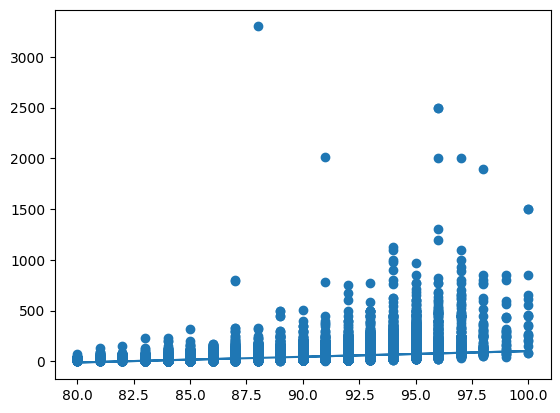

In [6]:
x = df['points']
y = df['price']

#points has 0 nulls, but price has 8996 nulls. 
#we need to take care of the nulls first.

#impute nulls with the mean.
y = y.fillna(y.mean())

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

In [7]:
print(r)

0.4161667418606234


In [8]:
df.corr()

,points,price
points,1.000000,0.416167
price,0.416167,1.000000


#### With a correlation coefficient of .4, this shows a slight positive relationship. This is a weaker relationship than I expected. I am hoping that introducing more variables into the model will improve the predictability of the model.

In [9]:
#prediction for review points of 88 and 100
print(myfunc(88))
print(myfunc(100))

32.99769333266096
100.28771016311964


#### Multivariate Regression
#### Using the machine learning package Sklearn is better for more complex models.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [11]:
#'description' will not be used, however this feature has the potential for sentiment analysis
target = 'price'
numerical_features = ['points']
categorical_features = ['country', 'designation', 'province', 'region_1', 'region_2', 'title', 'variety', 'winery']

#### Train/Test Split: 80% Train|20% Test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target),df[target], test_size=0.2, random_state=42)

#### Confirm 80% of the data is X_train

In [13]:
X_train['title'].value_counts()

Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)          8
Segura Viudas NV Extra Dry Sparkling (Cava)                     7
Korbel NV Brut Sparkling (California)                           7
Boizel NV Brut Réserve  (Champagne)                             6
Segura Viudas NV Aria Estate Extra Dry Sparkling (Cava)         6
                                                               ..
Carol Shelton 2012 Wild Thing Old Vine Zinfandel (Mendocino)    1
Domaine de l'Idylle 2016 Cruet Jacquère (Savoie)                1
Washington Hills 2013 Riesling (Washington)                     1
Testarossa 2013 Meritage (Santa Cruz Mountains)                 1
Dolin 2014 Rose of Pinot Noir (Central Coast)                   1
Name: title, Length: 90128, dtype: int64

In [14]:
df['title'].value_counts()

Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)                                   11
Korbel NV Brut Sparkling (California)                                                     9
Segura Viudas NV Extra Dry Sparkling (Cava)                                               8
Ruinart NV Brut Rosé  (Champagne)                                                         7
Segura Viudas NV Aria Estate Extra Dry Sparkling (Cava)                                   7
                                                                                         ..
Chateau Ste. Michelle 2013 Canoe Ridge Estate Cabernet Sauvignon (Horse Heaven Hills)     1
Masottina NV Cartizze Dry  (Prosecco Superiore di Cartizze)                               1
Turning Leaf 2006 Reserve Merlot (California)                                             1
Nugan Family Estates 2015 Third Generation Chardonnay (South Eastern Australia)           1
Francis Ford Coppola 2007 Diamond Collection Black Label Claret (California)    

#### Feature Engineering Pipeline

In [15]:
# Impute any missing values with the mean
# Scale data between 0 and 1
# Generate degree-2 Polynomial features
numeric_pipeline = Pipeline(steps=[  
    ('impute', SimpleImputer(strategy='mean')),     
    ('scale', MinMaxScaler()),     
    ('polynomial',PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)), 
])

In [16]:
# Impute any missing values with the most frequently seen value
# OneHotEncode categorical features
categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(drop='first',handle_unknown = 'ignore')) 
])

In [17]:
pre_processor = ColumnTransformer(transformers=[
    ('numeric', numeric_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features),
])

#### Using this pipeline

In [18]:
X_train_proc = pre_processor.fit_transform(X_train)

In [19]:
X_test_proc = pre_processor.transform(X_test)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1, 2, 3, 5, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [20]:
X_train_proc.shape

(96780, 138626)

In [21]:
X_test_proc.shape

(24195, 138626)

#### Model Fitting

In [22]:
lin_reg_pipeline = Pipeline(steps=[
    ('preprocess', pre_processor),
    ('linearmodel', LinearRegression(fit_intercept=False)) 
])

In [23]:
df['price'].isnull().values.any() 

False

In [24]:
lin_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures())]),
                                                  ['points']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['country', 'designation',
                                                   'province', 'region_1',
                                                   'region_2', 'title',
                                                   'variety', 'winery'])])),
                ('linearmodel', LinearRegression(fit_intercept=False))])

In [25]:
y_hat_train = lin_reg_pipeline.predict(X_train)
print("Training MSE:", mean_squared_error(y_train, y_hat_train))

Training MSE: 5.546869910366877


In [26]:
y_hat_test = lin_reg_pipeline.predict(X_test)
print("Testing MSE:", mean_squared_error(y_test, y_hat_test))

Testing MSE: 560.1176625486052
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1, 2, 3, 5, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Plot distribution of predicted vs actual values.


<AxesSubplot: ylabel='Count'>

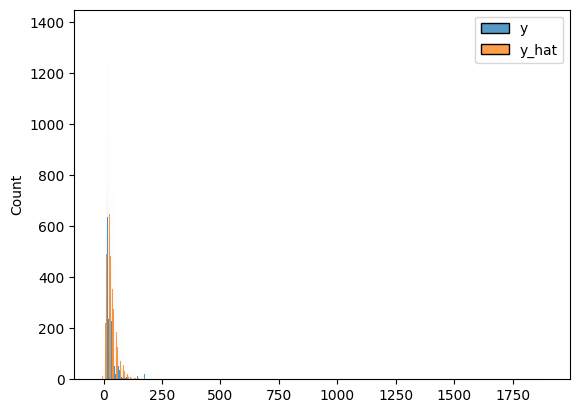

In [27]:
sns.histplot({'y':y_test, 'y_hat':y_hat_test},discrete=True, multiple='dodge') 

<AxesSubplot: ylabel='Count'>

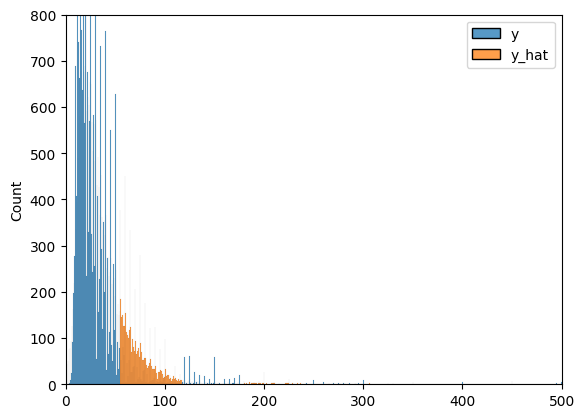

In [28]:
plt.xlim(0, 500)
plt.ylim(0, 800)
sns.histplot({'y':y_test, 'y_hat':y_hat_test},discrete=True, multiple='dodge') 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c684e12a-2caf-4332-a376-3ad8608a07be' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>